In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os

In [2]:
dataset = np.load("utils//preprocessed.npz")
x = dataset['x']

In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam

In [92]:
def generator(noise_shape):
    model = Sequential(name='generator')
    
    # Implementing DCGAN
    # Random Noise to 4x4x1024
    model.add(Dense(4*4*1024, input_shape=[noise_shape]))
    
    # Reshape reverse into 1024x4x4
    model.add(Reshape([4, 4, 1024]))
    
    # 512x8x8
    model.add(Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 2), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    # 256x16x16
    model.add(Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    # 128x32x32
    model.add(Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding="same"))
    model.add(BatchNormalization())
    model.add(ReLU())
    
    # 3x64x64
    # Output with tanh
    model.add(Conv2DTranspose(3, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='tanh'))
    
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy')
    
    return model

generator = generator(100)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 16384)             1654784   
_________________________________________________________________
reshape_11 (Reshape)         (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_43 (Conv2DT (None, 8, 8, 256)         4194560   
_________________________________________________________________
batch_normalization_54 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
re_lu_33 (ReLU)              (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_44 (Conv2DT (None, 16, 16, 128)       524416    
_________________________________________________________________
batch_normalization_55 (Batc (None, 16, 16, 128)       51

In [93]:
def discriminator():
    model = Sequential(name='discriminator')
    model.add(Conv2D(64, (3, 3), padding='same', strides=(2,2), input_shape=[64, 64, 3]))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU())
    
    model.add(Conv2D(64, (3, 3), padding='same', strides=(2,2), input_shape=[64, 64, 3]))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU())
    
    model.add(Flatten())
    
    model.add(Dense(128))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    opt = Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

discriminator = discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_57 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_23 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
batch_normalization_58 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 16384)           

In [94]:
discriminator.trainable = False
gan = Sequential([generator, discriminator])

gan.compile(optimizer=Adam(0.0002), loss='binary_crossentropy')
gan.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
generator (Sequential)       (None, 64, 64, 3)         6508419   
_________________________________________________________________
discriminator (Sequential)   (None, 1)                 2136641   
Total params: 8,645,060
Trainable params: 6,507,523
Non-trainable params: 2,137,537
_________________________________________________________________


In [95]:
from IPython.display import clear_output

In [96]:
EPOCHS = 100
BATCH_SIZE = 64

In [99]:
def train(x, gan, discriminator, generator, EPOCHS, BATCH_SIZE, LATENT_DIMENSION=100):
    def generate_latent_point(n_samples, latent_dim):
        return np.random.uniform(-1, 1, size=[n_samples, latent_dim])
        
    def generate_real_sample(x, n_samples):
        # Generate Random Index with amount of n_samples
        idx = np.random.randint(0, x.shape[0], n_samples)
        
        # Real Labels using method soft and noisy labels Real Label (0.9 - 1.0)
        # This approach is necessary to trick the discriminator
        noise_labels = np.ones(shape=(n_samples, 1)) #- np.random.uniform(low=0.0, high=0.1, size=(n_samples, 1))
        
        return x[idx], noise_labels
    
    def generate_fake_sample(generator, n_samples, latent_dim):
        # Generate Points in latent space and predict output
        pred = generator.predict(generate_latent_point(n_samples, latent_dim))
        
        # Real Labels using method soft and noisy labels Fake Label (0.0 - 0.1)
        # This approach is necessary to trick the discriminator
        noise_labels = np.zeros(shape=(n_samples, 1)) #+ np.random.uniform(low=0.0, high=0.1, size=(n_samples, 1))
        
        return pred, noise_labels
    
    iter_delete = 0
    d_loss_fake_list = []
    d_loss_real_list = []
    g_loss_list = []
    
    batch_per_epoch = x.shape[0] // BATCH_SIZE
    half_batches = int(BATCH_SIZE / 2)
    
    with tf.device('/gpu:0'):
        for epoch in range(EPOCHS):
            for i in range(batch_per_epoch):
                # Random Image from dataset with the Real Label
                x_real, y_real = generate_real_sample(x, half_batches)
                # Update Discriminator model weights
                d_loss_real, acc_real = discriminator.train_on_batch(x_real, y_real)
                # Generate Fake Example
                x_fake, y_fake = generate_fake_sample(generator, half_batches, LATENT_DIMENSION)
                # Update Discriminator
                d_loss_fake, acc_fake = discriminator.train_on_batch(x_fake, y_fake)
                # Prepare point in Latent Space and the label
                x_gan = generate_latent_point(BATCH_SIZE, LATENT_DIMENSION)
                y_gan = np.ones((BATCH_SIZE, 1))
                # Update the generator via discriminator error
                g_loss = gan.train_on_batch(x_gan, y_gan)
                
                d_loss_real_list.append(d_loss_real)
                d_loss_fake_list.append(d_loss_fake)
                g_loss_list.append(g_loss)
                
                if iter_delete == 100:
                    clear_output(wait=True)
                    iter_delete = 0
                else:
                    print("Epoch :%d, batch :%d, d1_real:%.5f, d2_fake:%.5f, g_loss:%.3f, acc_real:%.3f, acc_fake:%.10f" % (epoch, i, d_loss_real, d_loss_fake, g_loss, acc_real, acc_fake))
                    iter_delete = iter_delete + 1

    return generator, discriminator, gan, [np.asarray(d_loss_real_list), np.asarray(d_loss_fake_list), np.asarray(g_loss_list)]


In [100]:
generator, discriminator, gan, history = train(x, gan, discriminator, generator, EPOCHS, BATCH_SIZE, 100)
history = np.asarray(history)

Epoch :0, batch :101, d1_real:0.0008355739, d2_fake:0.0000756846, g_loss:0.0000000406, acc_real:1.0000000000, acc_fake:1.0000000000
Epoch :0, batch :102, d1_real:0.0000004451, d2_fake:0.0000264733, g_loss:0.0000000528, acc_real:1.0000000000, acc_fake:1.0000000000
Epoch :0, batch :103, d1_real:0.0000240508, d2_fake:0.0000769853, g_loss:0.0000009863, acc_real:1.0000000000, acc_fake:1.0000000000
Epoch :0, batch :104, d1_real:0.0049080951, d2_fake:0.0000987676, g_loss:0.0000000349, acc_real:1.0000000000, acc_fake:1.0000000000
Epoch :0, batch :105, d1_real:0.0000184988, d2_fake:0.0001183263, g_loss:0.0000000521, acc_real:1.0000000000, acc_fake:1.0000000000
Epoch :0, batch :106, d1_real:0.0000301966, d2_fake:0.0000544241, g_loss:0.0000000279, acc_real:1.0000000000, acc_fake:1.0000000000
Epoch :0, batch :107, d1_real:0.0000345012, d2_fake:0.0000734397, g_loss:0.0000001284, acc_real:1.0000000000, acc_fake:1.0000000000
Epoch :0, batch :108, d1_real:0.0000057018, d2_fake:0.0001524109, g_loss:0.0

KeyboardInterrupt: 

In [11]:
generator.save("utils//generator_test1.h5")
discriminator.save("utils//discriminator_test1.h5")
gan.save("utils//gan_test1.h5")

In [12]:
model = generator

In [13]:
#noise = np.random.uniform(-1,1,size=[5,100])
noise = np.load("utils//noise.npz")
noise = noise['noise']

im = model.predict(noise)

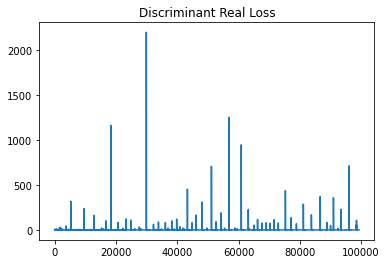

In [14]:
fig1 = plt.gcf()
plt.plot(history[0])
plt.title("Discriminant Real Loss")
plt.show()

fig1.savefig("utils/history/d_real1.jpg")

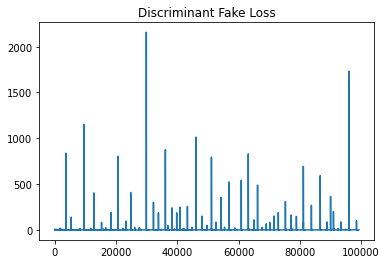

In [15]:
fig1 = plt.gcf()
plt.plot(history[1])
plt.title("Discriminant Fake Loss")
plt.show()

fig1.savefig("utils/history/d_fake1.jpg")

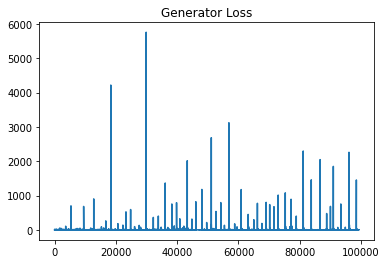

In [16]:
fig1 = plt.gcf()
plt.plot(history[2])
plt.title("Generator Loss")
plt.show()

fig1.savefig("utils/history/generator1.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


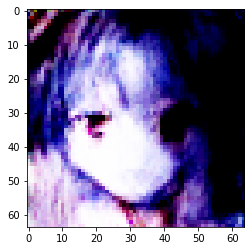

In [14]:
plt.imshow(im[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


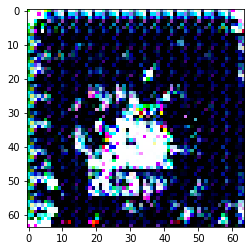

In [17]:
plt.imshow(im[3])

##### plt.imshow(im[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


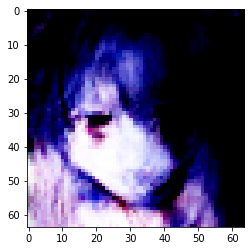

In [18]:
plt.imshow(im[6])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


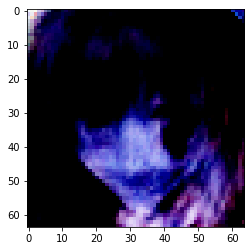

In [19]:
plt.imshow(im[7])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


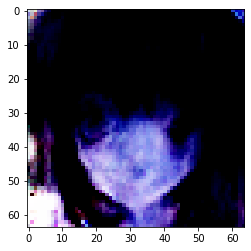

In [20]:
plt.imshow(im[8])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


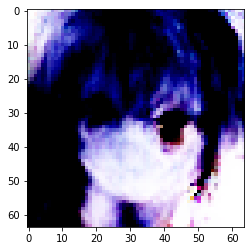

In [21]:
plt.imshow(im[9])